Audio sample rate: 16000 Hz


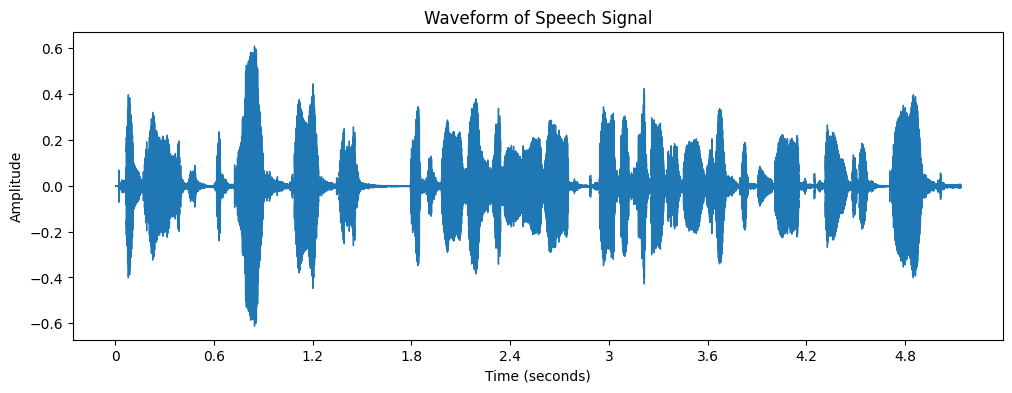

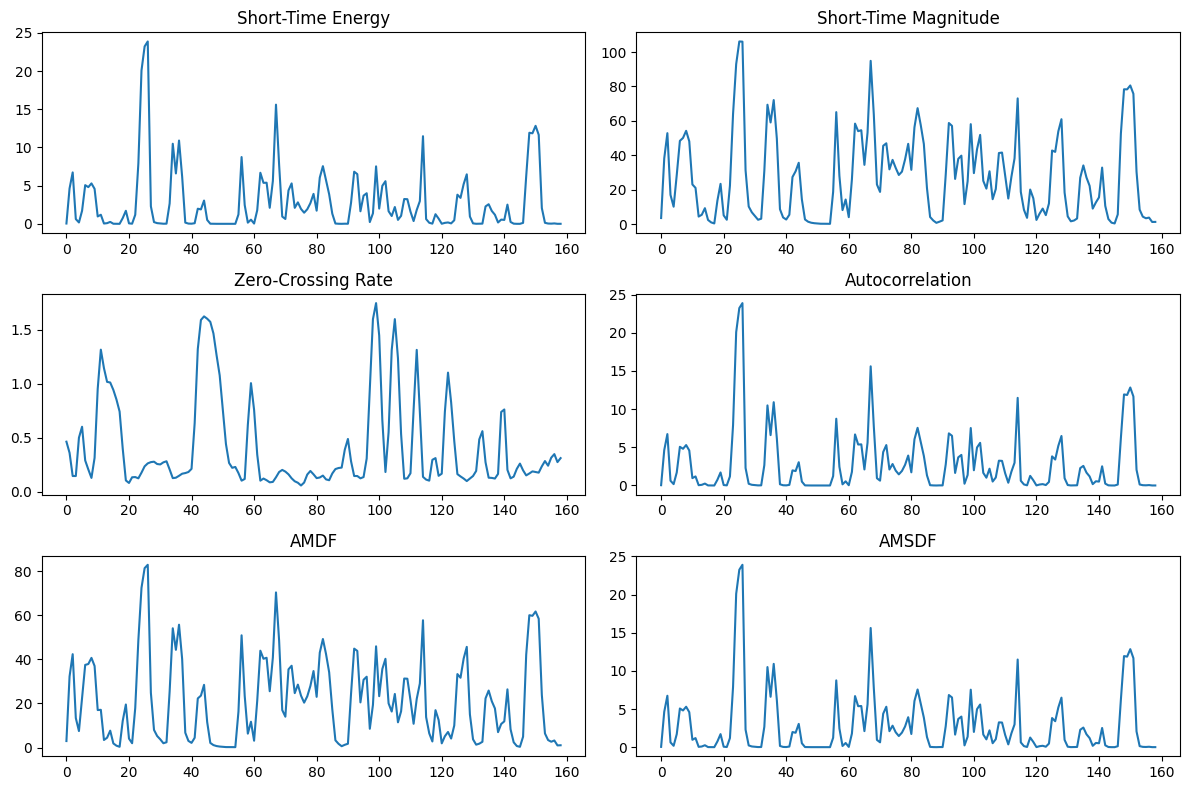

In [6]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf

def apply_hamming(frame):
    return frame * np.hamming(len(frame))

def short_time_energy(frame):
    return np.sum(frame ** 2)

def short_time_magnitude(frame):
    return np.sum(np.abs(frame))

def zero_crossing_rate(frame):
    return np.sum(np.abs(np.diff(np.sign(frame)))) / len(frame)

def autocorrelation(frame):
    return np.correlate(frame, frame, mode='full')[len(frame) - 1]

def amdf(frame):
    length = len(frame)
    return np.mean([np.sum(np.abs(frame[i:] - frame[:length - i])) for i in range(1, length)])

def amsdf(frame):
    length = len(frame)
    return np.mean([np.sum((frame[i:] - frame[:length - i])**2) for i in range(1, length)])

def extract_features(y, sr, frame_size=1024, hop_size=512):
    frames = librosa.util.frame(y, frame_length=frame_size, hop_length=hop_size).T
    hamming_frames = np.array([apply_hamming(frame) for frame in frames])

    ste = np.array([short_time_energy(frame) for frame in hamming_frames])
    stm = np.array([short_time_magnitude(frame) for frame in hamming_frames])
    zcr = np.array([zero_crossing_rate(frame) for frame in hamming_frames])
    ac = np.array([autocorrelation(frame) for frame in hamming_frames])
    amdf_vals = np.array([amdf(frame) for frame in hamming_frames])
    amsdf_vals = np.array([amsdf(frame) for frame in hamming_frames])

    return ste, stm, zcr, ac, amdf_vals, amsdf_vals

def plot_features(ste, stm, zcr, ac, amdf_vals, amsdf_vals):
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 2, 1)
    plt.plot(ste)
    plt.title("Short-Time Energy")

    plt.subplot(3, 2, 2)
    plt.plot(stm)
    plt.title("Short-Time Magnitude")

    plt.subplot(3, 2, 3)
    plt.plot(zcr)
    plt.title("Zero-Crossing Rate")

    plt.subplot(3, 2, 4)
    plt.plot(ac)
    plt.title("Autocorrelation")

    plt.subplot(3, 2, 5)
    plt.plot(amdf_vals)
    plt.title("AMDF")

    plt.subplot(3, 2, 6)
    plt.plot(amsdf_vals)
    plt.title("AMSDF")

    plt.tight_layout()
    plt.show()

# Load speech sample
y, sr = librosa.load('/content/LJ001-0004.wav', sr=None)

target_sr = 16000
if sr not in [16000, 44100]:
    y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    sr = target_sr
    sf.write('resampled_speech.wav', y, sr)

print(f"Audio sample rate: {sr} Hz")
# Plot waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("Waveform of Speech Signal")
plt.show()

# Extract features
ste, stm, zcr, ac, amdf_vals, amsdf_vals = extract_features(y, sr)

# Plot features
plot_features(ste, stm, zcr, ac, amdf_vals, amsdf_vals)